In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import chi2_contingency
from itertools import product

sns.set_style('dark')
sns.set_theme(style='darkgrid')
sns.set_palette(sns.color_palette("rocket"))

/tmp/ipykernel_4566/2562567361.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
data = pd.read_csv('../data/processed_files/processed_data.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2895398 entries, 0 to 2895397
Data columns (total 10 columns):
 #   Column              Dtype  
---  ------              -----  
 0   date                object 
 1   date_block_num      int64  
 2   shop_id             int64  
 3   item_id             int64  
 4   item_price          float64
 5   item_cnt_day        int64  
 6   item_name           object 
 7   item_category_id    int64  
 8   shop_name           object 
 9   item_category_name  object 
dtypes: float64(1), int64(5), object(4)
memory usage: 220.9+ MB


## look at correlations between target and other columns


In [4]:
target = 'item_cnt_day'
# divide columns into numerical and categorial
cat_cols = ['date_block_num', 'shop_id', 'item_id', 'item_category_id']
num_cols = ['item_price']

#### numerical data

In [5]:
def scatterplots(df: pd.DataFrame, columns: list[str], title: str = None):
    plt.figure(figsize=(20, 5))
    if title:
        plt.suptitle(title)
    for idx, col in enumerate(columns):
        plt.subplot(1, len(columns), idx+1)
        ax = sns.scatterplot(x=df[col], y=df[target], alpha=0.03, markers='+')
        ax.set_ylim(bottom=-3)
        ax.set_xlim(left=-0.1)
    plt.show()

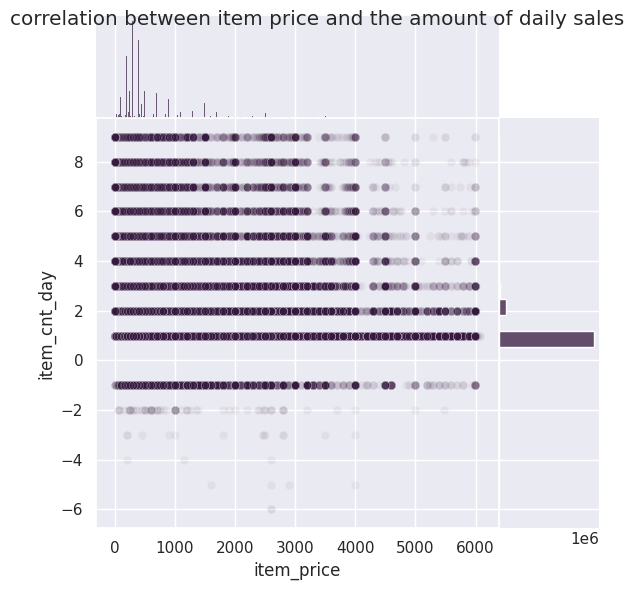

In [6]:
grid = sns.jointplot(data=data[['item_cnt_day', 'item_price']], x='item_price', y='item_cnt_day', space=0, ratio=4, joint_kws={'alpha':0.05})
grid.figure.suptitle('correlation between item price and the amount of daily sales')
plt.show()

From what we see on the figure, we can colclude that cheaper items are sold (and returned) more often overall, and items are mostly sold once or twice a day

#### categorial data

here I'm trying to see a distibution of the amount of items sold daily with respect to different values of categorial columns

In [7]:
def boxplots(df: pd.DataFrame, columns:list[str], title:str=None):
    if title:
        plt.suptitle(title)
    for idx, col in enumerate(columns):
        if col == 'item_id': continue
        plt.figure(figsize=(20, 5))  # *len(columns)
        data_to_plot = data[[target, col]].groupby(col).sum()
        #plt.subplot(len(columns), 1, idx+1)
        sns.barplot(data_to_plot, x=col, y=target)
        plt.show()  

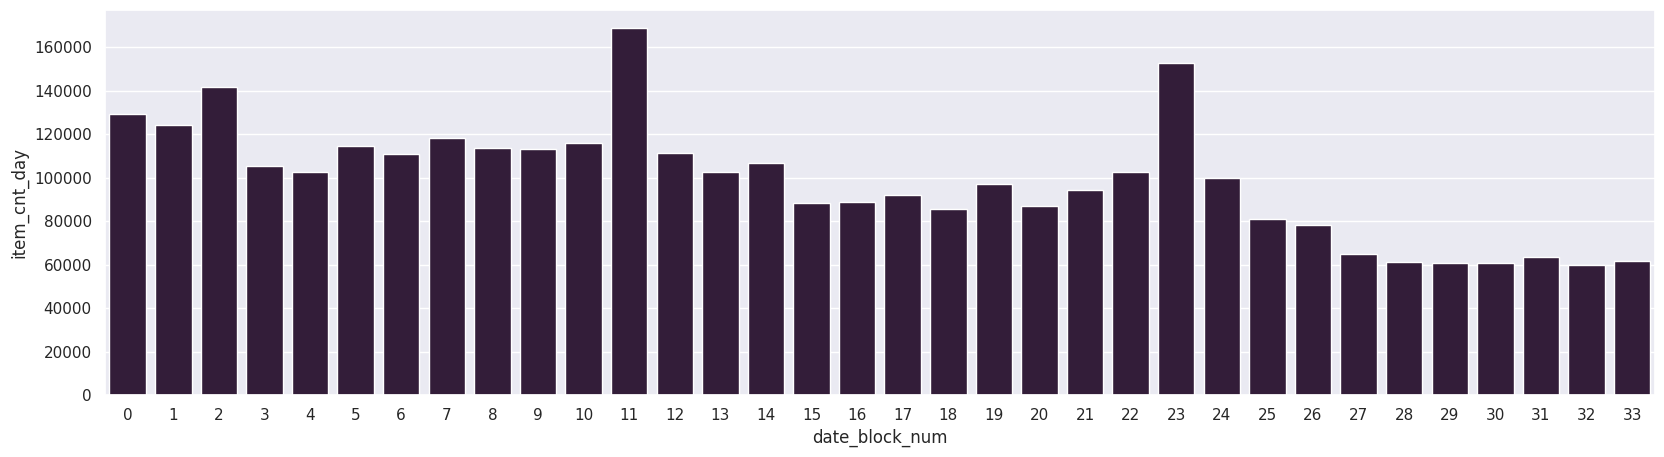

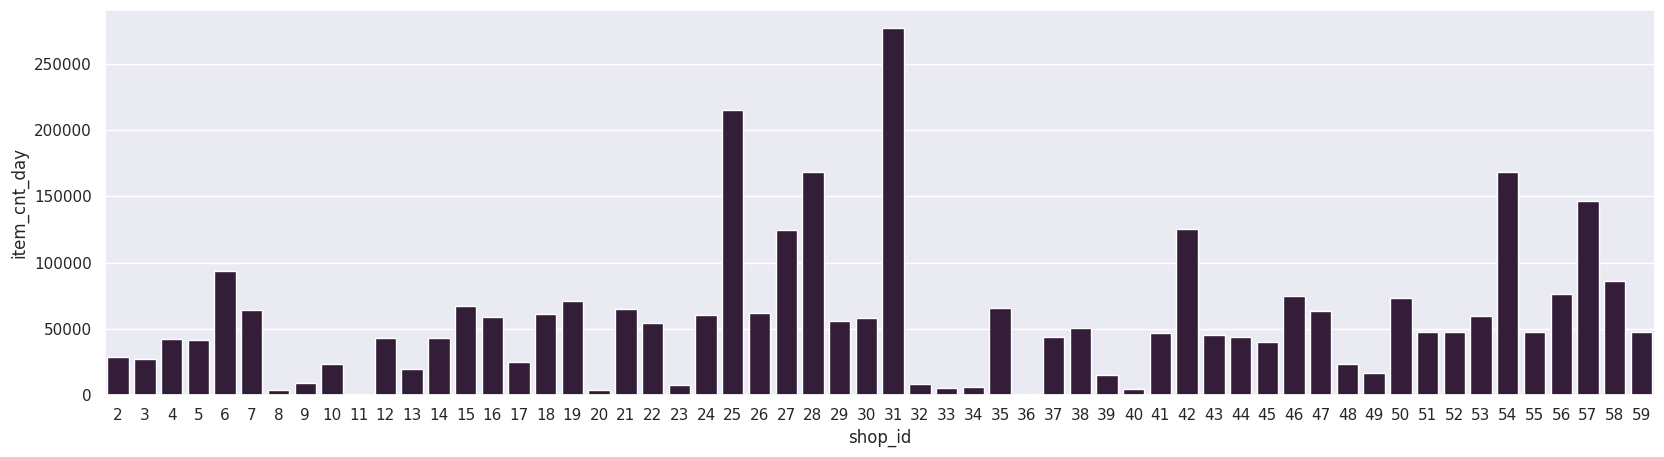

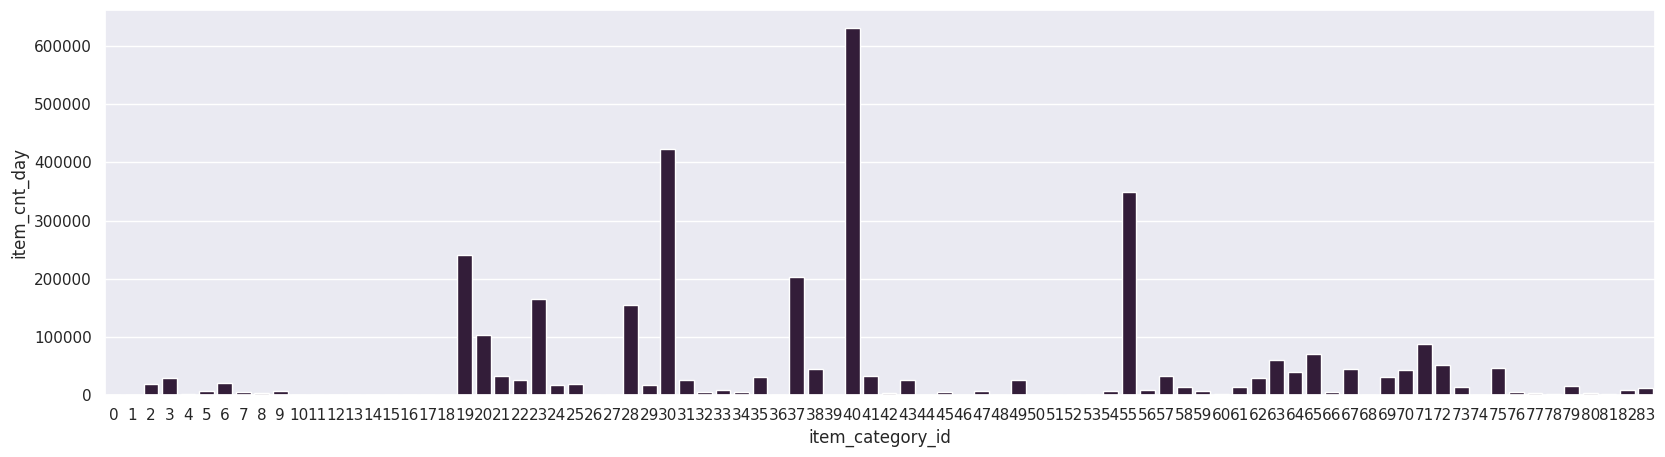

In [8]:
boxplots(data, cat_cols)

#TODO need to rework the item_id graph and add annots

we can see that teh amount of items sold increases every 12 months (which we already saa during DQC) and remains approx. the same during the whole period (though, the overall sales do decrease a little by the end of the period)

at the same time, we can see that the amount of items sold has quite a high variance depending on the category and the shop, so that gives us a hint that those two columns will be an important factor while predicting the future sales.

## correlations between other values

#### categorial features

first of all we can build contingency tables for different catrgorial features to se how they relate to each other.

In [17]:
def cont_tables(df: pd.DataFrame, columns: list[str]):
    template = "correlation between {:17} and {:17}\tchi-value: {:10.3f}, p-value: {:3.2f}, dof: {:9}"
    for col_1, col_2 in product(columns, repeat=2):
        if col_1==col_2: continue
        cont_table = pd.crosstab(df[col_1], df[col_2])
        chi, pvalue, dof, expectations = chi2_contingency(cont_table)
        print(template.format(col_1, col_2, chi, pvalue, dof))

In [18]:
cont_tables(data, cat_cols) #looks pretty weird to me :D

correlation between date_block_num    and shop_id          	chi-value: 447599.914, p-value: 0.00, dof:      1881
correlation between date_block_num    and item_id          	chi-value: 9318587.359, p-value: 0.00, dof:    711777
correlation between date_block_num    and item_category_id 	chi-value: 532772.557, p-value: 0.00, dof:      2739
correlation between shop_id           and date_block_num   	chi-value: 447599.914, p-value: 0.00, dof:      1881
correlation between shop_id           and item_id          	chi-value: 6336976.693, p-value: 0.00, dof:   1229433
correlation between shop_id           and item_category_id 	chi-value: 3863364.430, p-value: 0.00, dof:      4731
correlation between item_id           and date_block_num   	chi-value: 9318587.359, p-value: 0.00, dof:    711777
correlation between item_id           and shop_id          	chi-value: 6336976.693, p-value: 0.00, dof:   1229433
correlation between item_id           and item_category_id 	chi-value: 240318034.000, p-val

each pair of those has a p-value of 0, so that's weird, need to address this further